In [1]:
import numpy as np
import os, copy, sys
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

In [35]:
if torch.cuda.is_available():
    cuda = True
    device = torch.device('cuda')
    
X_dim = 28*28
Y_dim = 1
h_dim = 128
Z_dim = 100
    
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1.0 / (np.sqrt(in_dim/ 2.0))
    vec = torch.randn(*size)*xavier_stddev
    vec = vec.to(device)
    vec.requires_grad = True
    return vec
    
def init_bias(size):
    vec = torch.zeros(size)
    vec = vec.to(device)
    vec = Variable(vec, requires_grad = True)
    return vec

def loss(Input, target):
    return F.binary_cross_entropy(Input, target)

class generator(nn.Module):
    def __init__(self, ):
        super(generator, self).__init__()
        self.Wzh = nn.Parameter(xavier_init(size = [Z_dim, h_dim]))
        self.Whx = nn.Parameter(xavier_init(size = [h_dim, X_dim]))
        self.bgz = nn.Parameter(init_bias(h_dim))
        self.bgh = nn.Parameter(init_bias(X_dim))
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, z):
        h = F.relu(torch.mm(z, self.Wzh) + self.bgz)
        X = F.sigmoid(torch.mm(h, self.Whx) + self.bgh)
        return X
    
class discriminator(nn.Module):
    def __init__(self, ):
        super(discriminator, self).__init__()
        self.Wxh = nn.Parameter(xavier_init(size = [X_dim, h_dim]))
        self.Why = nn.Parameter(xavier_init(size = [h_dim, Y_dim]))
        self.bdx = nn.Parameter(init_bias(h_dim))
        self.bdh = nn.Parameter(init_bias(Y_dim))
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, X):
        h = F.relu(torch.mm(X, self.Wxh) + self.bdx)
        y = F.sigmoid(torch.mm(h, self.Why) + self.bdh)
        return y
    

In [15]:
G = generator()
for name, p in G.named_parameters():
    if p.requires_grad:
        print(name)
D = discriminator()
for name, p in D.named_parameters():
    if p.requires_grad:
        print(name)

Wzh
Whx
bgz
bgh
Wxh
Why
bdx
bdh


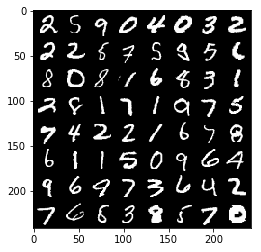

In [40]:
batchsize = 64
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0,), (1,))])
trainset = datasets.MNIST(root = '../init proj/pydata/', train = True, download = False, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batchsize, shuffle = True, num_workers = 2)

dataiter = iter(trainloader)
images, labels = dataiter.next()

def mnist_next(dataiter):
    try:
        images, labels = dataiter.next()
        images = images.view(images.numpy().shape[0], 28*28)
    except:
        dataiter = iter(trainloader)
        images, labels = dataiter.next()
        images = images.view(images.numpy().shape[0], 28*28)
    return images.numpy(), labels

images, labels = mnist_next(dataiter)
# print some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
img = torchvision.utils.make_grid(images)
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))


In [64]:
batchsize = 64
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0,), (1,))])
trainset = datasets.MNIST(root = '../init proj/pydata/', train = True, download = False, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batchsize, shuffle = True)

G = generator()
D = discriminator()
if cuda == True:
    G.cuda()
    D.cuda()
learning_rate = 0.0001
G_optim = optim.Adam(G.parameters(), lr = learning_rate)
D_optim = optim.Adam(D.parameters(), lr = learning_rate)



epochs = 10
for epoch in range(epochs):
    total_loss = 0
    G.train()
    D.train()
    for _, (X, Y) in enumerate(trainloader):
        z = torch.randn(batchsize, Z_dim)
        X = X.view(X.numpy().shape[0], 28*28)
        X, Y, z = Variable(X), Variable(Y), Variable(z)
        X, Y, z = X.cuda(), Y.cuda(), z.cuda()
        
        G_sample = G(z)
        D_real = D(X)
        D_fake = D(G_sample)
        
        ones_label = torch.ones(D_real.size()[0], 1)
        ones_label = ones_label.cuda()
        zeros_label = torch.zeros(D_fake.size()[0], 1)
        zeros_label = zeros_label.cuda()
        
        D_real_loss = loss(D_real, ones_label)
        D_fake_loss = loss(D_fake, zeros_label)
    
        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        D_optim.step()
        D.zero_grad()
        G.zero_grad()
    
        z = torch.randn(batchsize, Z_dim)
        z = Variable(z)
        z = z.cuda()
        G_sample = G(z)
        D_fake = D(G_sample)
        ones_label = torch.ones(D_fake.size()[0], 1)
        ones_label = ones_label.cuda()
    
        G_loss = loss(D_fake, ones_label)
        G_loss.backward()
        G_optim.step()
        G.zero_grad()
    
        total_loss += (D_loss.data[0] + G_loss.data[0])
    
    if epoch % 1 == 0:
        print('Epoch: {} Average loss: {:.4f}', format(epoch, total_loss.cpu().numpy()/len(trainloader.dataset)))
        
G.save(G.save_dict(), 'generator_dict')
D.save(D.save_dict(), 'discriminator_dict')


C:\Users\Abarn\AppData\Local\conda\conda\envs\mypython\lib\site-packages\ipykernel_launcher.py:59: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


TypeError: format() argument 2 must be str, not numpy.float64